In [1]:
#The objective is to cluster the generators of each type within the clusters of representative days
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import pairwise_distances
from operator import itemgetter
from datetime import date, timedelta
import json
from yellowbrick.cluster import KElbowVisualizer
import random


In [2]:
def get_total_load():
    """
    This function gives all information about the year 2020 regarding load and days
    """
    df = pd.read_csv("merged.csv")
    df.drop('Unnamed: 0', axis=1, inplace=True)
    is_output = df['Measurement'] == 'Output'
    df = df[is_output]
    df.drop('Measurement', axis=1, inplace=True)
    
    return df.groupby("Delivery Date").sum().T, list(df.groupby("Delivery Date").sum().index)[::]

In [3]:
def get_dates():
    start_date = date(2020, 1, 1)
    end_date = date(2020, 12, 30)
    delta = timedelta(days=1)
    dates = [0]
    while start_date <= end_date:
        dates.append(start_date.strftime("%Y-%m-%d"))
        start_date += delta
    
    return dates

In [4]:
def representative_days(numOfRepresentaveDaysInEachCluster):
    dates = get_dates()
    with open('./Capacity/solarDailyData.json', 'r') as openfile:
        solarDailyData = json.load(openfile)
    with open('./Capacity/windDailyData.json', 'r') as openfile:
        windDailyData = json.load(openfile)
    data = pd.read_csv('./Prepared_Demand.csv')

    dataRows = []
    dataRowsForClustering = []
    for i in range(1, 367):
        temp = []
        tempForClustering = []
        maxx = max(list(data.iloc[i-1][1:]))
        minn = min(list(data.iloc[i-1][1:]))
        diff = maxx - minn
        temp.extend(list(data.iloc[i-1][1:]))
        tempForClustering.extend(list((data.iloc[i-1][1:]-minn)/diff))

        temp.extend(solarDailyData[str(i)])
        tempForClustering.extend(solarDailyData[str(i)])
        temp.extend(windDailyData[str(i)])
        tempForClustering.extend(solarDailyData[str(i)])
        dataRows.append(temp)
        dataRowsForClustering.append(tempForClustering)

    kmeans = KMeans()
    visualizer = KElbowVisualizer(kmeans, k=(2,30), timings= True)
    visualizer.fit(np.array(dataRowsForClustering))       # Fit data to visualizer

    numClusters = visualizer.elbow_value_
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(dataRowsForClustering)
    y_kmeans = kmeans.predict(dataRowsForClustering)

    differences = {}
    for index1, i in enumerate(kmeans.cluster_centers_):
        difference = {}
        for index2, j in enumerate(dataRowsForClustering):
            if kmeans.labels_[index2] == index1:
                difference[index2] = np.sqrt(sum((i-j)**2))
        differences[index1] = difference    


    listOfDaysIndex = []
    for i in range(numClusters):
        daysInOneCluster = []
        for j in range(0, numOfRepresentaveDaysInEachCluster):
            daysInOneCluster.append(min(differences[i], key=differences[i].get))
            differences[i].pop(min(differences[i], key=differences[i].get))
        listOfDaysIndex.append(daysInOneCluster)

    listOfDays = []
    for i in range(numClusters):
        listOfDays.append(itemgetter(*listOfDaysIndex[i])(dates))

    listOfDaysWeights = []
    for i in range(numClusters):
        listOfDaysWeights.append(list(kmeans.labels_).count(i))

    weightsOfDays = dict()
    for ind, ite in enumerate(listOfDaysIndex):
        for ind2, ite2 in enumerate(ite):
            weightsOfDays[dates[ite2]] = listOfDaysWeights[ind] / numOfRepresentaveDaysInEachCluster
    

    if (numOfRepresentaveDaysInEachCluster == 1):
        D = listOfDays
        D_ = listOfDaysIndex
        D_ = [d[0] for d in D_]
    else:
        D = [listOfDays[t][k] for k in range(numOfRepresentaveDaysInEachCluster) for t in range(len(listOfDays))]
        D_ = [listOfDaysIndex[t][k] for k in range(numOfRepresentaveDaysInEachCluster) for t in range(len(listOfDays))]
    D_equ = {D[i]: j for i, j in enumerate(D_)}
    return D, D_, D_equ, weightsOfDays

In [5]:
np.random.seed(100)
random.seed(100)

In [6]:
start_date = date(2020, 1, 1)
end_date = date(2020, 12, 30)
delta = timedelta(days=1)
dates = [0]
while start_date <= end_date:
    dates.append(start_date.strftime("%Y-%m-%d"))
    start_date += delta

In [7]:
df = pd.read_csv("merged.csv")

with open('representativedaysDemand.json', 'r') as openfile:
    representativedaysDemand = json.load(openfile)

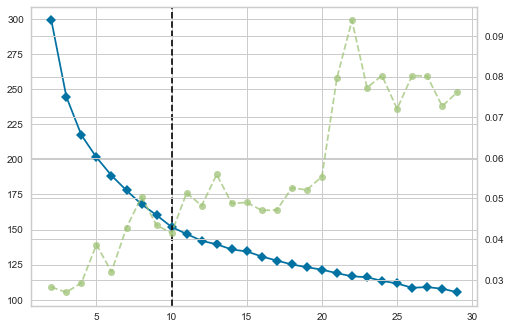

In [8]:
# D = [int(i) for i in list(representativedaysDemand.keys())[0:]]

# myDates = [dates[d] for d in D]
myDates = get_dates()

D, D_, D_equ, weightsOfDays = representative_days(1)

In [9]:
df = df[df["Delivery Date"].isin(myDates)]


df.drop('Unnamed: 0', axis=1, inplace=True)

is_output = df['Measurement'] == 'Output'
df = df[is_output]
df.drop('Measurement', axis=1, inplace=True)

is_nuclear = df['Fuel Type'] == 'NUCLEAR' 
df_nuclear = df[is_nuclear]

is_gas = df['Fuel Type'] == 'GAS' 
df_gas = df[is_gas]

is_hydro = df['Fuel Type'] == 'HYDRO' 
df_hydro = df[is_hydro]

is_biofuel = df['Fuel Type'] == 'BIOFUEL' 
df_biofuel = df[is_biofuel]

is_solar = df['Fuel Type'] == 'SOLAR' 
df_solar = df[is_solar]

is_wind = df['Fuel Type'] == 'WIND' 
df_wind = df[is_wind]

df_nuclear_copy = df_nuclear.copy()
df_gas_copy = df_gas.copy()
df_hydro_copy = df_hydro.copy()
df_biofuel_copy = df_biofuel.copy()
df_solar_copy = df_solar.copy()
df_wind_copy = df_wind.copy()

df_nuclear.drop('Fuel Type', axis=1, inplace=True)
df_nuclear.drop('Delivery Date', axis=1, inplace=True)

df_gas.drop('Fuel Type', axis=1, inplace=True)
df_gas.drop('Delivery Date', axis=1, inplace=True)

df_hydro.drop('Fuel Type', axis=1, inplace=True)
df_hydro.drop('Delivery Date', axis=1, inplace=True)

df_biofuel.drop('Fuel Type', axis=1, inplace=True)
df_biofuel.drop('Delivery Date', axis=1, inplace=True)

df_solar.drop('Fuel Type', axis=1, inplace=True)
df_solar.drop('Delivery Date', axis=1, inplace=True)

df_wind.drop('Fuel Type', axis=1, inplace=True)
df_wind.drop('Delivery Date', axis=1, inplace=True)

/var/folders/p2/_rg1c7j16cn87kgrsk75v7ph0000gn/T/ipykernel_39157/459464512.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nuclear.drop('Fuel Type', axis=1, inplace=True)
/var/folders/p2/_rg1c7j16cn87kgrsk75v7ph0000gn/T/ipykernel_39157/459464512.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nuclear.drop('Delivery Date', axis=1, inplace=True)
/var/folders/p2/_rg1c7j16cn87kgrsk75v7ph0000gn/T/ipykernel_39157/459464512.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

The data that I'm saving here helps me compare the production of my representative generators' production and their actual production in reality. __seems as though it might not have that much of use__

In [10]:
from sklearn.preprocessing import normalize

In [11]:
repres = {}
genWeights = {}
for gen in ["Gas", "Hydro"]:
    # if (gen == "Nuclear"):
    #     gg = df_nuclear
    if (gen == "Hydro"):
        gg = df_hydro
    elif (gen == "Gas"):
        gg = df_gas
    elif (gen == "Solar"):
        gg = df_solar
    elif (gen == "Wind"):
        gg = df_wind
    


    mySet = set(gg["Generator"])
    # print(mySet)
    
    # sth = gg[gg["Generator"] == generator]
    # gg = gg.drop(["Delivery Date", "Fuel Type"], axis=1)
    
    mergedGenerators = {i: list(filter((i).__ne__, list(itertools.chain.from_iterable(gg[gg["Generator"] == i].values.tolist())))) for i in mySet}
    
    # for k in mergedGenerators.keys():
    #     mergedGenerators[k] = normalize(np.array(mergedGenerators[k]).reshape(-1, 1))    
    

    values = list(mergedGenerators.values())
    
    # print(values)
    # print((values))
    
    kmeans = KMeans()
#     visualizer = KElbowVisualizer(kmeans, k=(2, 6), timings= True)
#     visualizer.fit(np.array(values))# Fit data to visualizer
#     visualizer.show()
    
#     numClusters = visualizer.elbow_value_
#     print(numClusters)
    
    numClusters = 5
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(values)
    y_kmeans = kmeans.predict(values)
    
    weights = []
    for qq in range(numClusters):
        ww = list(y_kmeans).count(qq)
        weights.append(ww)
    
    genWeights[gen] = weights
    
    differences = []
    for i in kmeans.cluster_centers_:
        difference = []
        for j in values:
            difference.append(np.sqrt(sum((i-j)**2)))
        differences.append(difference)
    
    listOfGenerators = []
    for i in range(numClusters):
        listOfGenerators.append(np.array(differences[i]).argmin())
    
    myRepresentativeGenerators = [list(mySet)[g] for g in listOfGenerators]
    
    print(f"{gen}: {myRepresentativeGenerators}")
    repres[gen] = myRepresentativeGenerators

/var/folders/p2/_rg1c7j16cn87kgrsk75v7ph0000gn/T/ipykernel_39157/954293895.py:23: DeprecationWarning: NotImplemented should not be used in a boolean context
  mergedGenerators = {i: list(filter((i).__ne__, list(itertools.chain.from_iterable(gg[gg["Generator"] == i].values.tolist())))) for i in mySet}


Gas: ['SITHE GOREWAY-G13', 'GREENFIELD ENERGY CENTRE-G1', 'NAPANEE-G3', 'STCLAIRCGS', 'GTAA-G3']


/var/folders/p2/_rg1c7j16cn87kgrsk75v7ph0000gn/T/ipykernel_39157/954293895.py:23: DeprecationWarning: NotImplemented should not be used in a boolean context
  mergedGenerators = {i: list(filter((i).__ne__, list(itertools.chain.from_iterable(gg[gg["Generator"] == i].values.tolist())))) for i in mySet}


Hydro: ['CHENAUX', 'BECK2', 'SAUNDERS', 'DESJOACHIMS', 'REDROCK']


/var/folders/p2/_rg1c7j16cn87kgrsk75v7ph0000gn/T/ipykernel_39157/4158648901.py:6: DeprecationWarning: NotImplemented should not be used in a boolean context
  mergedGenerators = {i: list(filter((i).__ne__, list(itertools.chain.from_iterable(gg[gg["Generator"] == i].values.tolist())))) for i in mySet}


(45, 8760)


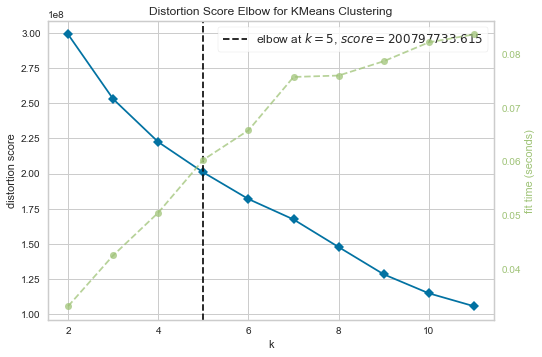

5
['KINGSBRIDGE', 'UNDERWOOD', 'DILLON', 'RAILBEDWF-LT.AG_SR', 'HENVEY NORTH']


In [12]:
for gen in ["Wind"]:
    gg = df_wind
    mySet = set(gg["Generator"])
    # print(mySet)
  
    mergedGenerators = {i: list(filter((i).__ne__, list(itertools.chain.from_iterable(gg[gg["Generator"] == i].values.tolist())))) for i in mySet}
    
    values = (list(mergedGenerators.values()))
    print(np.shape(values))
    
    kmeans = KMeans()
    visualizer = KElbowVisualizer(kmeans, k=(2,12), timings= True)
    visualizer.fit(np.array(values))# Fit data to visualizer
    visualizer.show()
    
    numClusters = visualizer.elbow_value_
    print(numClusters)
    
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(values)
    y_kmeans = kmeans.predict(values)
    
    weights = []
    for qq in range(numClusters):
        ww = list(y_kmeans).count(qq)
        weights.append(ww)
    
    genWeights[gen] = weights
    
    differences = []
    for i in kmeans.cluster_centers_:
        difference = []
        for j in values:
            difference.append(np.sqrt(sum((i-j)**2)))
        differences.append(difference)
    
    listOfGenerators = []
    for i in range(numClusters):
        listOfGenerators.append(np.array(differences[i]).argmin())
    
    myRepresentativeGenerators = [list(mySet)[g] for g in listOfGenerators]
    
    print(myRepresentativeGenerators)
    repres[gen] = myRepresentativeGenerators

(7, 8760)


/var/folders/p2/_rg1c7j16cn87kgrsk75v7ph0000gn/T/ipykernel_39157/752944739.py:6: DeprecationWarning: NotImplemented should not be used in a boolean context
  mergedGenerators = {i: list(filter((i).__ne__, list(itertools.chain.from_iterable(gg[gg["Generator"] == i].values.tolist())))) for i in mySet}


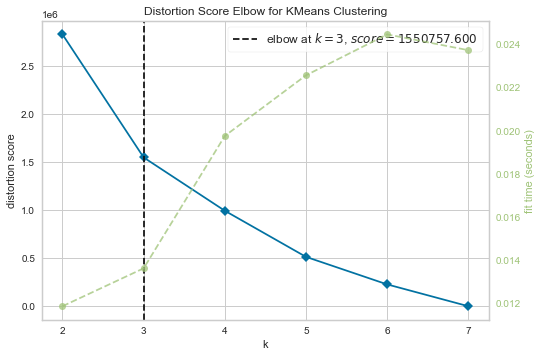

3
['KINGSTONSF', 'NANTICOKE SOLAR', 'GRANDSF']


In [13]:
for gen in ["Solar"]:
    gg = df_solar
    mySet = set(gg["Generator"])
    # print(mySet)
  
    mergedGenerators = {i: list(filter((i).__ne__, list(itertools.chain.from_iterable(gg[gg["Generator"] == i].values.tolist())))) for i in mySet}
    
    values = (list(mergedGenerators.values()))
    print(np.shape(values))
    
    kmeans = KMeans()
    visualizer = KElbowVisualizer(kmeans, k=(2,8), timings= True)
    visualizer.fit(np.array(values))# Fit data to visualizer
    visualizer.show()
    
    numClusters = visualizer.elbow_value_
    print(numClusters)
    
    kmeans = KMeans(n_clusters=numClusters)
    kmeans.fit(values)
    y_kmeans = kmeans.predict(values)
    
    weights = []
    for qq in range(numClusters):
        ww = list(y_kmeans).count(qq)
        weights.append(ww)
    
    genWeights[gen] = weights
    
    differences = []
    for i in kmeans.cluster_centers_:
        difference = []
        for j in values:
            difference.append(np.sqrt(sum((i-j)**2)))
        differences.append(difference)
    
    listOfGenerators = []
    for i in range(numClusters):
        listOfGenerators.append(np.array(differences[i]).argmin())
    
    myRepresentativeGenerators = [list(mySet)[g] for g in listOfGenerators]
    
    print(myRepresentativeGenerators)
    repres[gen] = myRepresentativeGenerators

In [14]:
from pprint import pprint
repres["Biofuel"] = ['CALSTOCKGS', 'THUNDERBAY-G3', 'TBAYBOWATER CTS', 'ATIKOKAN-G1']
pprint(repres)
jsonFormatted = json.dumps(repres)
with open("./newRampingConstraints/repres.json", "w") as outfile:
    outfile.write(jsonFormatted)

{'Biofuel': ['CALSTOCKGS', 'THUNDERBAY-G3', 'TBAYBOWATER CTS', 'ATIKOKAN-G1'],
 'Gas': ['SITHE GOREWAY-G13',
         'GREENFIELD ENERGY CENTRE-G1',
         'NAPANEE-G3',
         'STCLAIRCGS',
         'GTAA-G3'],
 'Hydro': ['CHENAUX', 'BECK2', 'SAUNDERS', 'DESJOACHIMS', 'REDROCK'],
 'Solar': ['KINGSTONSF', 'NANTICOKE SOLAR', 'GRANDSF'],
 'Wind': ['KINGSBRIDGE',
          'UNDERWOOD',
          'DILLON',
          'RAILBEDWF-LT.AG_SR',
          'HENVEY NORTH']}


In [15]:
genWeights["Biofuel"] = [1, 1, 1, 1]
pprint(genWeights)
jsonFormatted = json.dumps(genWeights)
with open("./newRampingConstraints/genWeights.json", "w") as outfile:
    outfile.write(jsonFormatted)

{'Biofuel': [1, 1, 1, 1],
 'Gas': [10, 7, 3, 1, 31],
 'Hydro': [7, 1, 1, 2, 45],
 'Solar': [1, 5, 1],
 'Wind': [17, 4, 19, 1, 4]}


In [16]:
# df_nuclear = df_nuclear_copy[df_nuclear_copy["Generator"].isin(repres["Nuclear"])]
# df_nuclear.to_excel("df_nuclear.xlsx")
df_gas = df_gas_copy[df_gas_copy["Generator"].isin(repres["Gas"])]
df_gas.to_excel("df_gas.xlsx")
df_hydro = df_hydro_copy[df_hydro_copy["Generator"].isin(repres["Hydro"])]
df_hydro.to_excel("df_hydro.xlsx")
df_solar = df_solar_copy[df_solar_copy["Generator"].isin(repres["Solar"])]
df_solar.to_excel("df_solar.xlsx")
df_wind = df_wind_copy[df_wind_copy["Generator"].isin(repres["Wind"])]
df_wind.to_excel("df_wind.xlsx")

repres["Biofuel"] = ['CALSTOCKGS', 'THUNDERBAY-G3', 'TBAYBOWATER CTS', 'ATIKOKAN-G1']
is_biofuel = df['Fuel Type'] == 'BIOFUEL' 
df_biofuel = df[is_biofuel]

In [17]:
real_gas_duration_curve = []
temp_df = df[df["Fuel Type"] == "GAS"].groupby("Delivery Date").sum()

for i in range(365):
    real_gas_duration_curve.extend(temp_df.iloc[i])

real_solar_duration_curve = []
temp_df = df[df["Fuel Type"] == "SOLAR"].groupby("Delivery Date").sum()

for i in range(365):
    real_solar_duration_curve.extend(temp_df.iloc[i])
    
real_wind_duration_curve = []
temp_df = df[df["Fuel Type"] == "WIND"].groupby("Delivery Date").sum()

for i in range(365):
    real_wind_duration_curve.extend(temp_df.iloc[i])

In [18]:
is_hydro = df['Fuel Type'] == 'HYDRO' 
df_hydro = df[is_hydro]

In [19]:
df_hydro

,Delivery Date,Generator,Fuel Type,Hour 1,Hour 2,Hour 3,Hour 4,Hour 5,Hour 6,Hour 7,...,Hour 15,Hour 16,Hour 17,Hour 18,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23,Hour 24
1,2020-08-01,ABKENORA,HYDRO,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6,2020-08-01,AGUASABON,HYDRO,18,18,3,1,19,20,1,...,33,33,33,32,32,33,32,32,33,33
8,2020-08-01,ALEXANDER,HYDRO,47,47,47,46,46,46,46,...,46,46,46,46,46,46,46,46,46,46
16,2020-08-01,APIROQUOIS,HYDRO,59,59,59,59,59,52,59,...,65,65,65,65,65,65,65,65,65,64
21,2020-08-01,ARNPRIOR,HYDRO,0,0,0,0,0,0,0,...,0,1,1,36,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152202,2020-05-31,STEWARTVLE,HYDRO,1,0,0,0,0,0,1,...,39,39,58,39,39,39,54,58,49,21
152226,2020-05-31,UMBATAFALLS,HYDRO,25,25,25,24,24,24,25,...,25,25,25,25,25,25,25,25,25,25
152231,2020-05-31,UPPER WHITE RIVER,HYDRO,8,8,8,8,8,8,8,...,8,8,8,8,8,8,8,8,8,8
152233,2020-05-31,WELLS,HYDRO,0,0,0,0,0,0,0,...,0,0,0,93,100,101,101,8,0,0


In [20]:
repres["Hydro"]

['CHENAUX', 'BECK2', 'SAUNDERS', 'DESJOACHIMS', 'REDROCK']

In [21]:
df_hydro[df_hydro["Generator"] == "CHENAUX"]

,Delivery Date,Generator,Fuel Type,Hour 1,Hour 2,Hour 3,Hour 4,Hour 5,Hour 6,Hour 7,...,Hour 15,Hour 16,Hour 17,Hour 18,Hour 19,Hour 20,Hour 21,Hour 22,Hour 23,Hour 24
85,2020-08-01,CHENAUX,HYDRO,48,48,48,49,50,65,66,...,83,96,96,96,95,94,94,79,79,65
501,2020-08-02,CHENAUX,HYDRO,64,49,49,49,49,65,68,...,83,97,97,97,96,95,94,81,81,65
917,2020-08-03,CHENAUX,HYDRO,50,50,50,34,34,34,68,...,98,98,97,97,96,96,95,81,80,80
1333,2020-08-04,CHENAUX,HYDRO,51,50,51,34,35,66,83,...,83,83,113,112,111,110,95,94,81,80
1749,2020-08-05,CHENAUX,HYDRO,66,51,34,50,51,82,84,...,114,114,113,112,110,110,95,82,82,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150261,2020-05-27,CHENAUX,HYDRO,82,82,83,83,84,84,84,...,113,125,123,122,121,121,120,106,80,81
150677,2020-05-28,CHENAUX,HYDRO,81,82,82,83,84,98,111,...,97,98,97,111,111,111,111,110,110,110
151093,2020-05-29,CHENAUX,HYDRO,96,97,97,98,98,98,112,...,110,114,112,111,123,110,109,109,96,96
151509,2020-05-30,CHENAUX,HYDRO,96,97,82,82,83,83,98,...,111,111,111,111,110,109,105,106,93,80


In [22]:
# Making a load duration curve for different technolgoies

gas_load_duration = []
wind_load_duration = []
solar_load_duration = []
hydro_load_duration = []

for index, d in enumerate(myDates[1: ]):
    my_df_gas = df_gas[df_gas["Delivery Date"] == d]
    my_df_gas = my_df_gas.drop(columns=["Delivery Date", "Fuel Type"], axis=1)
    
    my_df_solar = df_solar[df_solar["Delivery Date"] == d]
    my_df_solar = my_df_solar.drop(columns=["Delivery Date", "Fuel Type"], axis=1)

    my_df_wind = df_wind[df_wind["Delivery Date"] == d]
    my_df_wind = my_df_wind.drop(columns=["Delivery Date", "Fuel Type"], axis=1)

    my_df_hydro = df_hydro[df_hydro["Delivery Date"] == d]
    my_df_hydro = my_df_hydro.drop(columns=["Delivery Date", "Fuel Type"], axis=1)

    ### Hydro
    list_of_multiplied_generations = []
    for ind, gen in enumerate(repres["Hydro"]):
        df2 = my_df_hydro[my_df_hydro["Generator"] == gen]
        df2 = df2.drop(columns=["Generator"], axis=1)
        
        list_of_multiplied_generations.append(genWeights["Hydro"][ind] * df2.iloc[0])

    summed = [sum(i) for i in zip(*list_of_multiplied_generations)]
    hydro_load_duration.extend(summed)

    ### Gas
    list_of_multiplied_generations = []
    for ind, gen in enumerate(repres["Gas"]):
        df2 = my_df_gas[my_df_gas["Generator"] == gen]
        df2 = df2.drop(columns=["Generator"], axis=1)
    
        list_of_multiplied_generations.append(genWeights["Gas"][ind] * df2.iloc[0])

    summed = [sum(i) for i in zip(*list_of_multiplied_generations)]
    gas_load_duration.extend(summed)

    ### Solar
    list_of_multiplied_generations = []
    for ind, gen in enumerate(repres["Solar"]):
        df2 = my_df_solar[my_df_solar["Generator"] == gen]
        df2 = df2.drop(columns=["Generator"], axis=1)
    
        list_of_multiplied_generations.append(genWeights["Solar"][ind] * df2.iloc[0])

    summed = [sum(i) for i in zip(*list_of_multiplied_generations)]
    solar_load_duration.extend(summed)

    ### Wind
    list_of_multiplied_generations = []
    for ind, gen in enumerate(repres["Wind"]):
        df2 = my_df_wind[my_df_wind["Generator"] == gen]
        df2 = df2.drop(columns=["Generator"], axis=1)
    
        list_of_multiplied_generations.append(genWeights["Wind"][ind] * df2.iloc[0])

    summed = [sum(i) for i in zip(*list_of_multiplied_generations)]
    wind_load_duration.extend(summed)

In [23]:
np.shape(list_of_multiplied_generations)

(5, 24)

In [24]:
plt.style.use('ggplot')

In [25]:
# real_gas_duration_curve = []
# for i in range(365):
#     real_gas_duration_curve.extend(list(df_gas.groupby("Delivery Date").sum().iloc[i]))

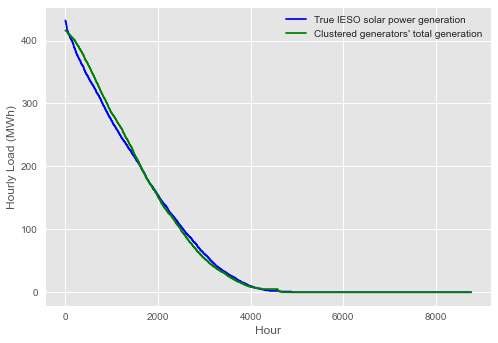

In [26]:
plt.plot(np.sort(real_solar_duration_curve)[::-1], color="blue", label="True IESO solar power generation")
plt.plot(np.sort(solar_load_duration)[::-1], color="green", label="Clustered generators' total generation")
plt.xlabel("Hour")
plt.ylabel("Hourly Load (MWh)")
plt.legend()

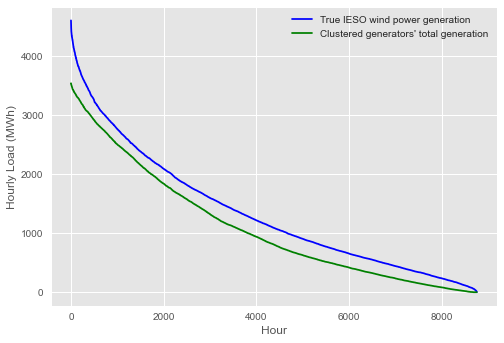

In [27]:
plt.plot(np.sort(real_wind_duration_curve)[::-1], color="blue", label="True IESO wind power generation")
plt.plot(np.sort(wind_load_duration)[::-1], color="green", label="Clustered generators' total generation")
plt.xlabel("Hour")
plt.ylabel("Hourly Load (MWh)")
plt.legend()

In [28]:
_1, _2 = get_total_load()

In [29]:
L__ = {(t, d, s): list(dict(_1)[d])[s-1] for t in range(1, 21) for ind_d, d in enumerate(_2) for s in range(1, 25)}
for ind, ite in enumerate(range(1, 21)):
    for d in _2:
        for s in range(1, 25):
            if (ite == 1):
                pass
            else:
                L__[ite, d, s] = 1.017 * L__[ite-1, d, s]

In [30]:
repres

{'Gas': ['SITHE GOREWAY-G13',
  'GREENFIELD ENERGY CENTRE-G1',
  'NAPANEE-G3',
  'STCLAIRCGS',
  'GTAA-G3'],
 'Hydro': ['CHENAUX', 'BECK2', 'SAUNDERS', 'DESJOACHIMS', 'REDROCK'],
 'Wind': ['KINGSBRIDGE',
  'UNDERWOOD',
  'DILLON',
  'RAILBEDWF-LT.AG_SR',
  'HENVEY NORTH'],
 'Solar': ['KINGSTONSF', 'NANTICOKE SOLAR', 'GRANDSF'],
 'Biofuel': ['CALSTOCKGS', 'THUNDERBAY-G3', 'TBAYBOWATER CTS', 'ATIKOKAN-G1']}

In [31]:
is_nuclear = df['Fuel Type'] == 'NUCLEAR' 
df_nuclear = df[is_nuclear]

In [32]:
df_nuclear2 = df_nuclear.groupby(["Delivery Date"]).sum()

In [33]:
nuclear_list = []
for day in dict(df_nuclear2.T).keys():
    nuclear_list.extend(list(df_nuclear2.T[day]))

In [34]:
total = []

for inde, ite in enumerate(nuclear_list):
    total.append(nuclear_list[inde] + wind_load_duration[inde] + solar_load_duration[inde] + gas_load_duration[inde] + hydro_load_duration[inde])



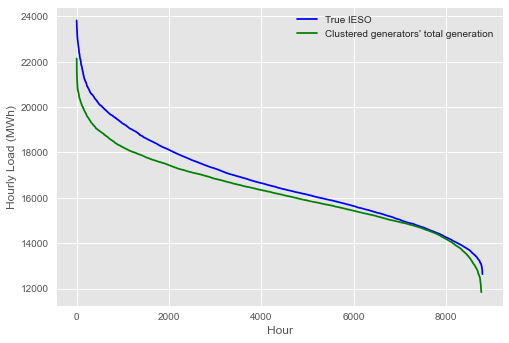

In [35]:
plt.plot(np.sort([L__[1, d, s] for d in _2 for s in range(1, 25)])[::-1], color="blue", label="True IESO")
plt.plot(np.sort(total)[::-1], color="green", label="Clustered generators' total generation")
plt.xlabel("Hour")
plt.ylabel("Hourly Load (MWh)")
plt.legend()

In [36]:
repres

{'Gas': ['SITHE GOREWAY-G13',
  'GREENFIELD ENERGY CENTRE-G1',
  'NAPANEE-G3',
  'STCLAIRCGS',
  'GTAA-G3'],
 'Hydro': ['CHENAUX', 'BECK2', 'SAUNDERS', 'DESJOACHIMS', 'REDROCK'],
 'Wind': ['KINGSBRIDGE',
  'UNDERWOOD',
  'DILLON',
  'RAILBEDWF-LT.AG_SR',
  'HENVEY NORTH'],
 'Solar': ['KINGSTONSF', 'NANTICOKE SOLAR', 'GRANDSF'],
 'Biofuel': ['CALSTOCKGS', 'THUNDERBAY-G3', 'TBAYBOWATER CTS', 'ATIKOKAN-G1']}

In [41]:
listOfTypes = ["Gas", "Hydro", "Biofuel"]
bindingHoursForEachGenerator = {}
for typ in listOfTypes:
    generators_ramp_rates = {}
    for generator in repres[typ]:
        if (typ == "Nuclear"):
            new_df = df_nuclear[df_nuclear["Generator"] == generator]
        elif (typ == "Gas"):
            new_df = df_gas[df_gas["Generator"] == generator]
        elif (typ == "Hydro"):
            new_df = df_hydro[df_hydro["Generator"] == generator]
        else:
            new_df = df_biofuel[df_biofuel["Generator"] == generator]
        ramp_up = []
        ramp_up_which_hours = []
        ramp_down = []
        ramp_down_which_hours = []
        for index, row in new_df.iterrows():
            productions = list(row)[3:]
            dif = [0]
            for i in range(1, 24):
                dif.append(productions[i] - productions[i - 1])
            
            listOfMax = np.flatnonzero(dif == np.max(dif))
    
            max_index = np.argmax(dif)
            #count_up.append(dif.count(dif[max_index]))
            
            listOfMin = np.flatnonzero(dif == np.min(dif))
    
            min_index = np.argmin(dif)
            #count_down.append(dif.count(dif[min_index]))
            
            ramp_up.append(dif[max_index])
            ramp_up_which_hours.append({row["Delivery Date"]: [str(k + 1) for k in listOfMax]})
            ramp_down.append(dif[min_index])
            ramp_down_which_hours.append({row["Delivery Date"]: [str(k + 1) for k in listOfMin]})
    
        try:
            generators_ramp_rates[generator] = {"ru": ([ramp_up_which_hours[gg] for gg in np.flatnonzero(ramp_up == np.max(ramp_up))], str(max(ramp_up))), "rd": (ramp_down_which_hours[np.argmin(ramp_down)], str(min(ramp_down)))}
        except:
            print(ramp_up)
    bindingHoursForEachGenerator[typ] = generators_ramp_rates

In [42]:
pprint(bindingHoursForEachGenerator)

{'Biofuel': {'ATIKOKAN-G1': {'rd': ({'2020-07-16': ['18']}, '-93'),
                             'ru': ([{'2020-04-16': ['20']}], '122')},
             'CALSTOCKGS': {'rd': ({'2020-10-19': ['11']}, '-25'),
                            'ru': ([{'2020-02-10': ['7']}], '20')},
             'TBAYBOWATER CTS': {'rd': ({'2020-09-02': ['19']}, '-31'),
                                 'ru': ([{'2020-05-13': ['6']}], '31')},
             'THUNDERBAY-G3': {'rd': ({'2020-08-01': ['1',
                                                      '2',
                                                      '3',
                                                      '4',
                                                      '5',
                                                      '6',
                                                      '7',
                                                      '8',
                                                      '9',
                                                  

In [43]:
pd.DataFrame(bindingHoursForEachGenerator).to_csv("./newRampingConstraints/bindingHoursForEachGenerator.csv")

In [44]:
jsonFormatted = json.dumps(bindingHoursForEachGenerator)
with open("./newRampingConstraints/bindingHoursForEachGenerator.json", "w") as outfile:
    outfile.write(jsonFormatted)

Here, I'm trying to find the capability of different generators in a data-diven appraoch and based on the data from 2020.

In [45]:
listOfTypes = ["Gas", "Hydro", "Wind", "Solar"]

In [46]:
# finding the capabilities of each of these representative generators we found
df = pd.read_csv("merged.csv")
capability = {}
for typ in listOfTypes:
    capabilityOfGenerators = {}
    for generator in repres[typ]:
        df_type = df[df["Fuel Type"] == typ.upper()]
        df_type_generator = df_type[df_type["Generator"] == generator]
        df_type_generator_capability = df_type_generator[df_type_generator["Measurement"] == "Output"]
        
        maximum_capability = []
        for index, row in df_type_generator_capability.iterrows():
            max_capability = np.max(list(row)[5: ])
            maximum_capability.append(max_capability)
        
        
        capabilityOfGenerators[generator] = np.max(maximum_capability)
    
    capability[typ] = capabilityOfGenerators


In [47]:
pprint(capability)
myCopiedCapability = capability.copy()

for typ in listOfTypes:
    for generator in repres[typ]:
        myCopiedCapability[typ][generator] = str(myCopiedCapability[typ][generator])
jsonFormatted = json.dumps(myCopiedCapability)
with open("./newRampingConstraints/capability.json", "w") as outfile:
    outfile.write(jsonFormatted)

{'Gas': {'GREENFIELD ENERGY CENTRE-G1': 195,
         'GTAA-G3': 27,
         'NAPANEE-G3': 447,
         'SITHE GOREWAY-G13': 207,
         'STCLAIRCGS': 585},
 'Hydro': {'BECK2': 1438,
           'CHENAUX': 128,
           'DESJOACHIMS': 404,
           'REDROCK': 37,
           'SAUNDERS': 1002},
 'Solar': {'GRANDSF': 99, 'KINGSTONSF': 98, 'NANTICOKE SOLAR': 44},
 'Wind': {'DILLON': 78,
          'HENVEY NORTH': 115,
          'KINGSBRIDGE': 39,
          'RAILBEDWF-LT.AG_SR': 264,
          'UNDERWOOD': 181}}


In [48]:
# finding the difference of right and left hand side of supply-demand constraints
totalProductionOfEachType = {t: {} for t in ['Nuclear', 'Gas', 'Hydro', 'Biofuel']}
eachGeneratorProductionEachDay = {t: {representativeDate: {} for representativeDate in set(df_nuclear["Delivery Date"])} for t in ['Nuclear', 'Gas', 'Hydro', 'Biofuel']}
for typ in ['Nuclear', 'Gas', 'Hydro', 'Biofuel']:
    for representativeDate in set(df_nuclear["Delivery Date"]):
        totalProductionOfEachOfGeneratorsDate = []
        for index, generator in enumerate(repres[typ]):
            
            if (typ == 'Nuclear'):
                my_df = df_nuclear
            elif (typ == 'Gas'):
                my_df = df_gas
            elif (typ == 'Hydro'):
                my_df = df_hydro
            else:
                my_df = df_biofuel
            
            my_df = my_df[(my_df["Generator"] == generator)]
            my_df = my_df[(my_df["Delivery Date"] == representativeDate)]
            
            production = list(my_df.iloc[0])[3: ]
            
            eachGeneratorProductionEachDay[typ][representativeDate][generator] = production
            
            if (typ == "Biofuel"):
                generatorTotalProduction = [production[hour] for hour in range(24)]
            else:
                generatorTotalProduction = [production[hour] * genWeights[typ][index] for hour in range(24)]
            
            totalProductionOfEachOfGeneratorsDate.append(generatorTotalProduction)
        
        
    
        totalProductionOfEachType[typ][representativeDate] = list(np.array(totalProductionOfEachOfGeneratorsDate).sum(axis=0))
        

KeyError: 'Nuclear'

Here, I can use `totalProductionOfEachType` to compare my optimization results to the reality and see if it makes sense, _hopefully_!

In [ ]:
totalProductionOfEachType

I want to save this for future use.

In [ ]:
pd.DataFrame(totalProductionOfEachType['Nuclear']).to_csv('./Inverse optimization/Aggregated productions of each representative generator/nuclear.csv')
pd.DataFrame(totalProductionOfEachType['Gas']).to_csv('./Inverse optimization/Aggregated productions of each representative generator/gas.csv')
pd.DataFrame(totalProductionOfEachType['Hydro']).to_csv('./Inverse optimization/Aggregated productions of each representative generator/hydro.csv')
pd.DataFrame(totalProductionOfEachType['Biofuel']).to_csv('./Inverse optimization/Aggregated productions of each representative generator/biofuel.csv')

In [ ]:
pprint(eachGeneratorProductionEachDay)
pd.DataFrame(eachGeneratorProductionEachDay).to_csv("./newRampingConstraints/eachGeneratorProductionEachDay.csv")

In [ ]:
with open('demandOfDays.json', 'r') as openfile:
    demandOfDays = json.load(openfile)

my_df = df[((df["Fuel Type"] == "SOLAR") | (df["Fuel Type"] == "WIND"))]
my_df = my_df[my_df["Measurement"] == "Output"]
solar_wind = my_df[my_df["Delivery Date"].isin(myDates)]
total_renewable_days = solar_wind.groupby("Delivery Date").sum()
total_renewable_days = total_renewable_days.reset_index()

total_renewable_days[total_renewable_days["Delivery Date"] == "2020-07-17"]

demand_keys = list(demandOfDays.keys())
demand_minus_reneables_days = {}
for index, date in enumerate(myDates):
    a = list(total_renewable_days[total_renewable_days["Delivery Date"] == date].iloc[0])[2: ]
    b = demandOfDays[demand_keys[index]]
    c = [int(z[1]) - int(z[0]) for z in zip(a, b)]
    demand_minus_reneables_days[date] = c
demand_minus_reneables_days

In [ ]:
demand_minus_reneables_days["2020-07-24"]

In [ ]:
importExport = {}
demands = {}
for index, date in enumerate(myDates):
    final = np.array([totalProductionOfEachType[typ][date] for typ in ['Nuclear', 'Gas', 'Hydro', 'Biofuel']]).sum(axis=0)
    
    demand = demand_minus_reneables_days[date]
    demands[date] = demand
    importExport[date] = [t[0] - t[1] for t in zip(demand, final)]

In [ ]:
pd.DataFrame(demands).to_csv("./demandsMinusIER.csv")

In [ ]:
pprint(importExport)
pd.DataFrame(importExport).to_csv("./newRampingConstraints/importExport.csv")

In [ ]:
eachGeneratorProductionEachDay["Nuclear"]["2020-07-17"]

In [ ]:
#Do we have binding constraints in productions limits?
bindingCapacity = {t: {representativeDate: {} for representativeDate in set(df_nuclear["Delivery Date"])} for t in ['Nuclear', 'Gas', 'Hydro', 'Biofuel']}
for representativeDate in set(df_nuclear["Delivery Date"]):
    for typ in ['Nuclear', 'Gas', 'Hydro', 'Biofuel']:
        for index, generator in enumerate(repres[typ]):
            if (eachGeneratorProductionEachDay[typ][representativeDate][generator].count(capability[typ][generator]) != 0):
                
                index = eachGeneratorProductionEachDay[typ][representativeDate][generator].index(capability[typ][generator])
                bindingCapacity[typ][representativeDate][generator] = index + 1

In [ ]:
pprint(bindingCapacity)
pd.DataFrame(bindingCapacity).to_csv("./newRampingConstraints/bindingCapacity.csv")